# Pytorchを使ってCIFAR10データセットのAIモデルを作る

### モジュールのインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\hokut\デスクトップ\practice\Pytorch_model\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPUの検証を行う
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### データセットのダウンロード

In [3]:
dataset = torchvision.datasets.CIFAR10(root="./dataset/", download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))

Files already downloaded and verified


In [4]:
print(dataset)
print(type(dataset))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
<class 'torchvision.datasets.cifar.CIFAR10'>


In [5]:
dataset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


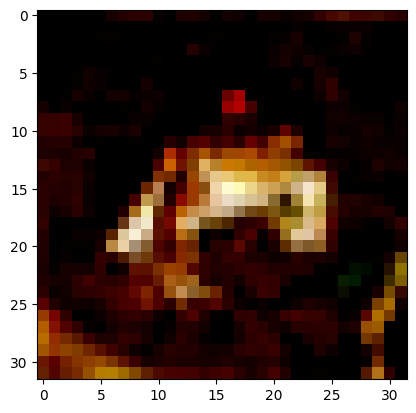

In [6]:
# 最初の画像を表示してみる
image, label = dataset[0]

image = image.permute(1, 2, 0)

plt.imshow(image)
print(label) # flog

### 各ラベルの名前を設定する

インデックストラベルの関係は以下の通り

- 0: airplane </br>
- 1: car</br>
- 2: bird</br>
- 3: cat</br>
- 4: deer</br>
- 5: dog</br>
- 6: frog</br>
- 7: horse</br>
- 8: ship</br>
- 9: truck</br>



In [7]:
label_name = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### DataLoader()をそれぞれ作成する

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('./dataset/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])), batch_size=128, shuffle=False)

Files already downloaded and verified


### ネットワークを作成する

層が大きくなると計算するのに時間がかかりそうだったので、とりあえず以下のサイトのモデルをそのまま実装してみる

- [my_CNN](https://kdl-di.hatenablog.com/entry/2021/12/24/090000)
- [my_CNN2](https://rightcode.co.jp/blog/information-technology/pytorch-cifar-10-cnn-learning-gpu-dropout)

In [9]:
# class my_CNN(nn.Module):

#     def __init__(self):
#         super().__init__()

#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)

#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x

class my_CNN2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 6, 5, 1, 0)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
 
        self.pool = torch.nn.MaxPool2d(2, 2)
 
        self.dropout1 = torch.nn.Dropout2d(p=0.3)  
 
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)  
        self.dropout2 = torch.nn.Dropout(p=0.5)  
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)  
        x = x.view(-1, 16 * 5 * 5)  
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)   
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

### 損失関数と最適化関数を定義する

`optimizer`はたくさんの種類があったが、今回は`Adam`, `SGD`の2種類を使って比較してみる

In [10]:
model = my_CNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, momentum=0.9)

### モデルの学習を開始する

トレーニング、テストをすべてここで行っているため若干効率は悪そう。<br>
あとローカルでやっているからかもしれない

今回は50回の学習を行い40回目の学習で学習率を変換して実装してみる

In [11]:
loss_history = []
train_acc = []
valid_acc = []
test_acc = []
epoch = 50

for e in range(epoch):
    loss_epoch = 0

    # 40回目の学習の時に学習率を変更する
    if e == 40:
        optimizer.param_groups[0]['lr'] = 1e-4
        print("chenged learning rate to 1e-4")

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        loss_epoch += loss.item()

        optimizer.step()
        
    print(f"training log: {e + 1} epoch ({(i+1) * 128}) Loss: {loss.item()}")

    loss_history.append(loss_epoch)
    model.eval()

# train_dataset
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        print(correct)
    
        acc = float(correct / 50000)
        train_acc.append(acc)

# test dataset
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        
        acc = float(correct / 10000)
        test_acc.append(acc)

    


### 損失の様子を視覚化する

Text(0, 0.5, 'loss')

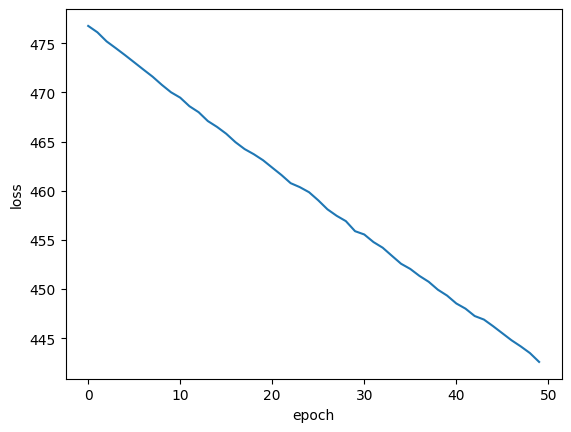

In [ ]:
plt.plot(loss_history)
plt.xlabel("epoch")
plt.ylabel("loss")

### 学習の結果を視覚化する

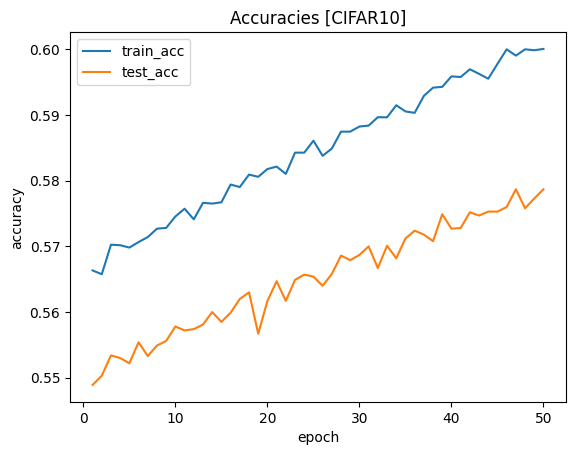

In [ ]:
plt.plot(range(1, epoch + 1), train_acc, label='train_acc')
plt.plot(range(1, epoch + 1), test_acc, label='test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()